# Image Classification Project 6
Choose three classes from the Open Images Dataset. Train a neural net that is able to classify images into these three categories.



In [29]:
classes = ['Cat', 'Dog', 'Person']
print(classes)

['Cat', 'Dog', 'Person']


## Dataset
https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection

## Base model
VGG 19

In [30]:
# imports
import os
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from openimages import download
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf

# check gpus
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print name of gpu
tf.config.experimental.list_physical_devices('GPU')


Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
# Path to the directory where the images are stored
base_dir = './dataset'

# Create the base directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Check if the directory exists
if os.path.exists(base_dir):
    # Delete the directory and its contents
    shutil.rmtree(base_dir)

train_size = 2000
test_size = 600

# Download images for each class using Open Images
download.download_dataset(dest_dir=base_dir+"/train", class_labels=classes, limit=train_size)

# Download images for each class using Open Images
download.download_dataset(dest_dir=base_dir+"/test", class_labels=classes, limit=test_size)

2023-06-11  00:32:59 INFO Downloading 2000 train images for class 'cat'
100%|██████████| 2000/2000 [01:41<00:00, 19.74it/s]
2023-06-11  00:34:40 INFO Downloading 2000 train images for class 'dog'
100%|██████████| 2000/2000 [02:13<00:00, 14.98it/s]
2023-06-11  00:36:54 INFO Downloading 2000 train images for class 'person'
100%|██████████| 2000/2000 [03:50<00:00,  8.66it/s]
2023-06-11  00:42:48 INFO Downloading 600 train images for class 'cat'
100%|██████████| 600/600 [00:38<00:00, 15.52it/s]
2023-06-11  00:43:27 INFO Downloading 600 train images for class 'dog'
100%|██████████| 600/600 [00:49<00:00, 12.19it/s]
2023-06-11  00:44:17 INFO Downloading 600 train images for class 'person'
100%|██████████| 600/600 [00:37<00:00, 15.82it/s]


{'cat': {'images_dir': './dataset/test\\cat\\images'},
 'dog': {'images_dir': './dataset/test\\dog\\images'},
 'person': {'images_dir': './dataset/test\\person\\images'}}

## Task
1. Preparation: Split dataset into a 70/30 Train/test split


In [32]:
# change classes to lower case
classes = [x.lower() for x in classes]


IMAGE_SIZE = [224, 224] #Default image size for VGG19

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
#Through flow_from_directory - we create an array of images that can be used for training.
training_set = datagen.flow_from_directory(base_dir+"/train", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')
#Through flow_from_directory - we create an array of images that can be used for test.
test_set = datagen.flow_from_directory(base_dir+"/test", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 6000 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


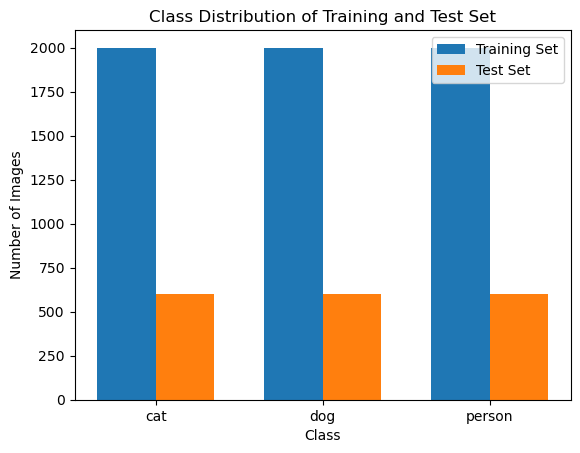

In [33]:
# Get the class labels and their indices
class_labels = training_set.class_indices

# Get the number of images in the training set
num_training_images = training_set.classes.shape[0]

# Get the number of images in the test set
num_test_images = test_set.classes.shape[0]

# Calculate the class counts for the training set
training_class_counts = [0] * len(class_labels)
for i in range(num_training_images):
    class_index = training_set.classes[i]
    training_class_counts[class_index] += 1

# Calculate the class counts for the test set
test_class_counts = [0] * len(class_labels)
for i in range(num_test_images):
    class_index = test_set.classes[i]
    test_class_counts[class_index] += 1

# Get the class labels as a list
labels = list(class_labels.keys())

# Plotting the class distribution
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_class_counts, width, label='Training Set')
rects2 = ax.bar(x + width/2, test_class_counts, width, label='Test Set')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution of Training and Test Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

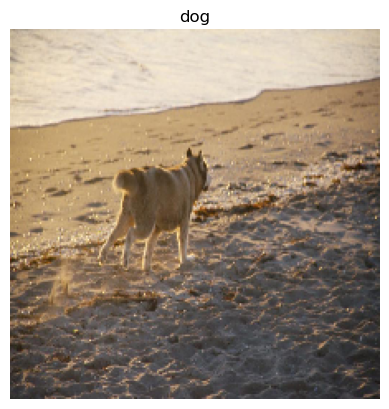

In [34]:
# Get the first batch of images and labels from the training set
images, labels = next(training_set)

# Retrieve the first image and its label
image = images[1]
label = labels[1]

# Get the class labels
class_labels = list(training_set.class_indices.keys())

# Get the corresponding label text
label_text = class_labels[np.argmax(label)]

# Display the first image with the label as the title
plt.imshow(image)
plt.axis('off')
plt.title(label_text)
plt.show()

2. Train a VGG19 network from scratch (randomly initialized weights) and estimate the testset accuracy.

### VGG19 with no weights and normal training data

In [35]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_no_weights_normal = Model(inputs=vgg.input, outputs=prediction)
vgg19_no_weights_normal.summary()
#Compile the model
vgg19_no_weights_normal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_normal_history = vgg19_no_weights_normal.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)
# Save the model
vgg19_no_weights_normal.save("models/vgg19_no_weights_normal.h5")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

3. Use an imagenet pretrained VGG19 network, train the model and estimate the testset accuracy.

### VGG19 with imagenet weights and normal training data

In [36]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_imagenet_normal = Model(inputs=vgg.input, outputs=prediction)
vgg19_imagenet_normal.summary()

#Compile the model
vgg19_imagenet_normal.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_normal_history = vgg19_imagenet_normal.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_normal.save("models/vgg19_imagenet_normal.h5")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### The differences in loss and accuracy of the plain and pre trained network over the first 10 epochs

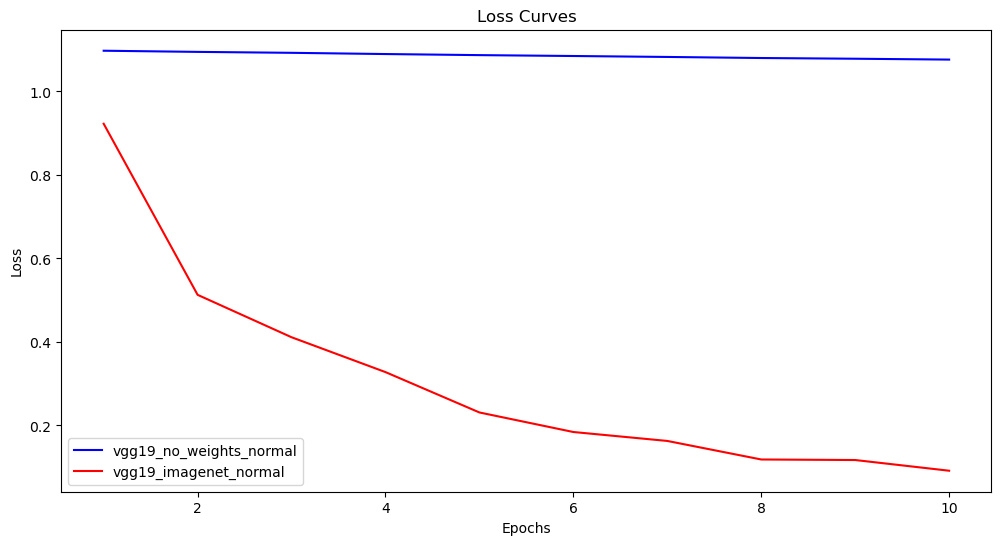

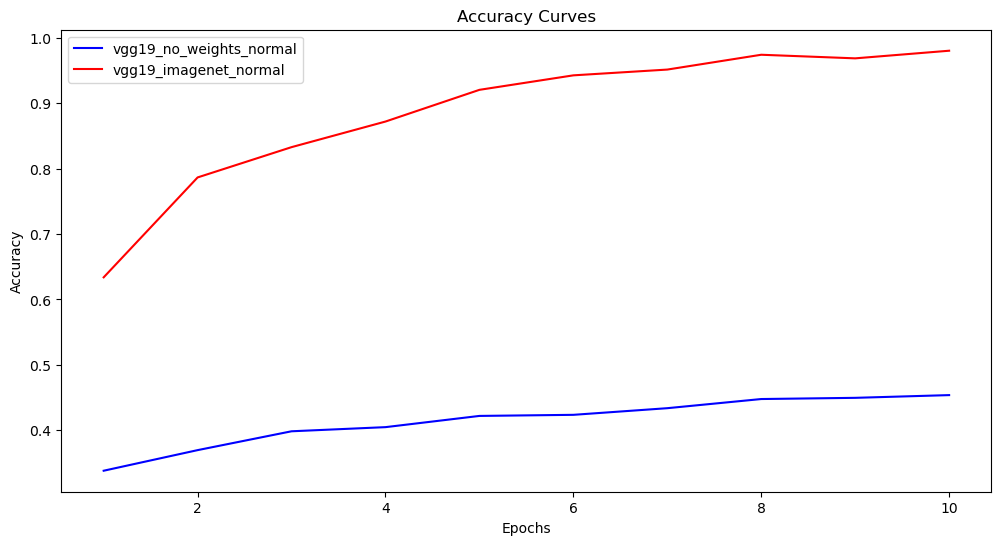

In [37]:
# Extract loss and accuracy values for both models
vgg19_no_weights_normal_loss = vgg19_no_weights_normal_history.history['loss']
vgg19_no_weights_normal_accuracy = vgg19_no_weights_normal_history.history['accuracy']
vgg19_imagenet_normal_loss = vgg19_imagenet_normal_history.history['loss']
vgg19_imagenet_normal_accuracy = vgg19_imagenet_normal_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_loss, 'b-', label='vgg19_no_weights_normal')
plt.plot(range(1, 11), vgg19_imagenet_normal_loss, 'r-', label='vgg19_imagenet_normal')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_accuracy, 'b-', label='vgg19_no_weights_normal')
plt.plot(range(1, 11), vgg19_imagenet_normal_accuracy, 'r-', label='vgg19_imagenet_normal')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4. Data cleansing: Remove “bad” images from the dataset. Which did you remove? How many? Discuss results.

In [43]:
# remove everything that is duplicate --> duplicate images
# remove everything that is too blurry --> quality control
# remove everything that is too small --> quality control

import cv2

# write a function that removes duplicates from directory dataset/train and counts how many deleted and prints which file was deleted
def remove_duplicates(path):
    # get all files in directory
    files = os.listdir(path)
    # create empty list for duplicates
    duplicates = []
    # create empty list for non duplicates
    non_duplicates = []
    # loop through all files
    for file in files:
        # check if file is a jpg
        if file.endswith(".jpg"):
            # read image
            image = cv2.imread(path + "/" + file)
            # convert image to string
            image_string = image.tostring()
            # check if image is already in non duplicates list
            if image_string in non_duplicates:
                # if yes, add to duplicates list
                duplicates.append(file)
            else:
                # if no, add to non duplicates list
                non_duplicates.append(image_string)
    # print how many duplicates were found
    print("Found " + str(len(duplicates)) + " duplicates.")
    # loop through duplicates list
    for duplicate in duplicates:
        # remove duplicate from directory
        os.remove(path + "/" + duplicate)
        # print which file was deleted
        print("Deleted " + duplicate)

# write a function that removes all files that are too small from directory dataset/train and counts how many deleted and prints which file was deleted
def remove_too_small(path):
    # get all files in directory
    files = os.listdir(path)
    # create empty list for too small files
    too_small = []
    # loop through all files
    for file in files:
        # check if file is a jpg
        if file.endswith(".jpg"):
            # read image
            image = cv2.imread(path + "/" + file)
            # get image height
            height = image.shape[0]
            # get image width
            width = image.shape[1]
            # check if image is too small
            if height < 224 or width < 224:
                # if yes, add to too small list
                too_small.append(file)
    # print how many too small files were found
    print("Found " + str(len(too_small)) + " too small files.")
    # loop through too small list
    for file in too_small:
        # remove too small file from directory
        os.remove(path + "/" + file)
        # print which file was deleted
        print("Deleted " + file)

# write a function that removes all files that are too blurry from directory dataset/train and counts how many deleted and prints which file was deleted
def remove_too_blurry(path):
    # get all files in directory
    files = os.listdir(path)
    # create empty list for too blurry files
    too_blurry = []
    # loop through all files
    for file in files:
        # check if file is a jpg
        if file.endswith(".jpg"):
            # read image
            image = cv2.imread(path + "/" + file)
            # convert image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # calculate variance of laplacian
            fm = cv2.Laplacian(gray, cv2.CV_64F).var()
            # check if image is too blurry
            if fm < 100:
                # if yes, add to too blurry list
                too_blurry.append(file)
    # print how many too blurry files were found
    print("Found " + str(len(too_blurry)) + " too blurry files.")
    # loop through too blurry list
    for file in too_blurry:
        # remove too blurry file from directory
        os.remove(path + "/" + file)
        # print which file was deleted
        print("Deleted " + file)

remove_duplicates("dataset/train")
remove_too_small("dataset/train")
remove_too_blurry("dataset/train")





Found 0 duplicates.
Found 0 too small files.
Found 0 too blurry files.


5. Add data augmentation: 
    - Random flip
    - Random contrast
    - Random translation

In [44]:
def random_contrast(image):
    image = tf.image.adjust_contrast(image, contrast_factor=2)
    return image

In [45]:
augmented_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.3,
    horizontal_flip=True,  # Apply random flip
    vertical_flip=True,  # Apply random flip
    width_shift_range=0.2,  # Apply random translation
    height_shift_range=0.2,  # Apply random translation
    preprocessing_function=random_contrast,  # Apply random contrast
)

#Through flow_from_directory - we create an array of images that can be used for training.
augmented_training_set = augmented_datagen.flow_from_directory(base_dir+"/train", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')


# test_set = datagen.flow_from_directory(base_dir+"/test", target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 6000 images belonging to 3 classes.


#### Train both models again

2023-06-11  01:10:19 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


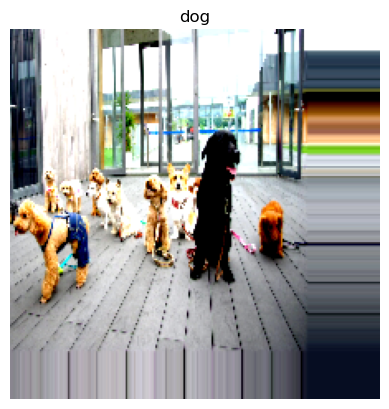

In [49]:
# Get the first batch of images and labels from the training set
images, labels = next(augmented_training_set)

# Retrieve the first image and its label
image = images[1]
label = labels[1]

# Get the class labels
class_labels = list(augmented_training_set.class_indices.keys())

# Get the corresponding label text
label_text = class_labels[np.argmax(label)]

# Display the first image with the label as the title
plt.imshow(image)
plt.axis('off')
plt.title(label_text)
plt.show()

### VGG19 with imagenet weights and augmented training data

In [50]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_no_weights_augmented = Model(inputs=vgg.input, outputs=prediction)
vgg19_no_weights_augmented.summary()
#Compile the model
vgg19_no_weights_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_augmented_history = vgg19_no_weights_augmented.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)
# Save the model
vgg19_no_weights_augmented.save("models/vgg19_no_weights_augmented.h5")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### VGG19 with imagenet weights and augmented training data

In [51]:
# Use this line for VGG19 network
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# This sets the base that the layers are not trainable.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(classes), activation='softmax')(x) # We have 3 classes

#Creating model object
vgg19_imagenet_augmented = Model(inputs=vgg.input, outputs=prediction)
vgg19_imagenet_augmented.summary()

#Compile the model
vgg19_imagenet_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_augmented_history = vgg19_imagenet_augmented.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_augmented.save("models/vgg19_imagenet_augmented.h5")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

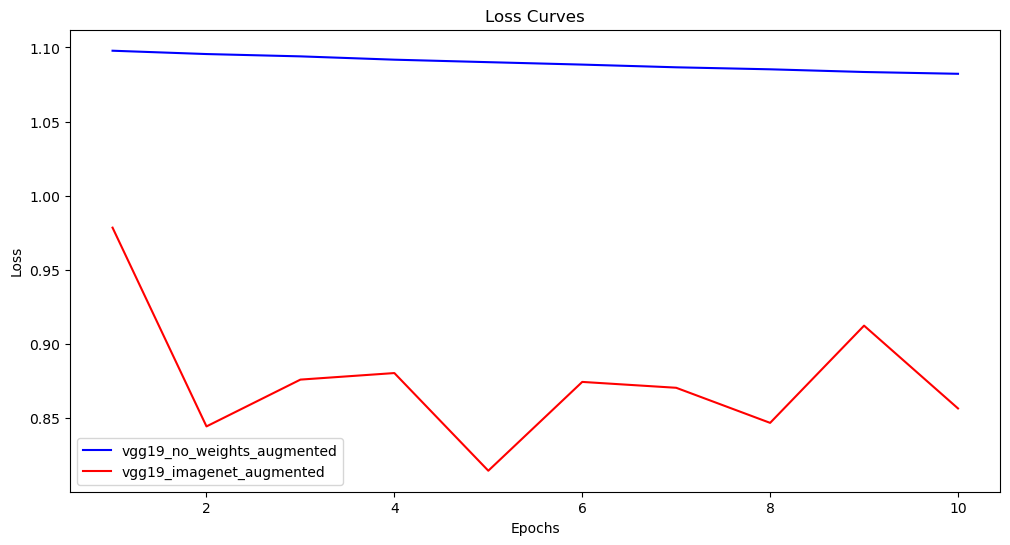

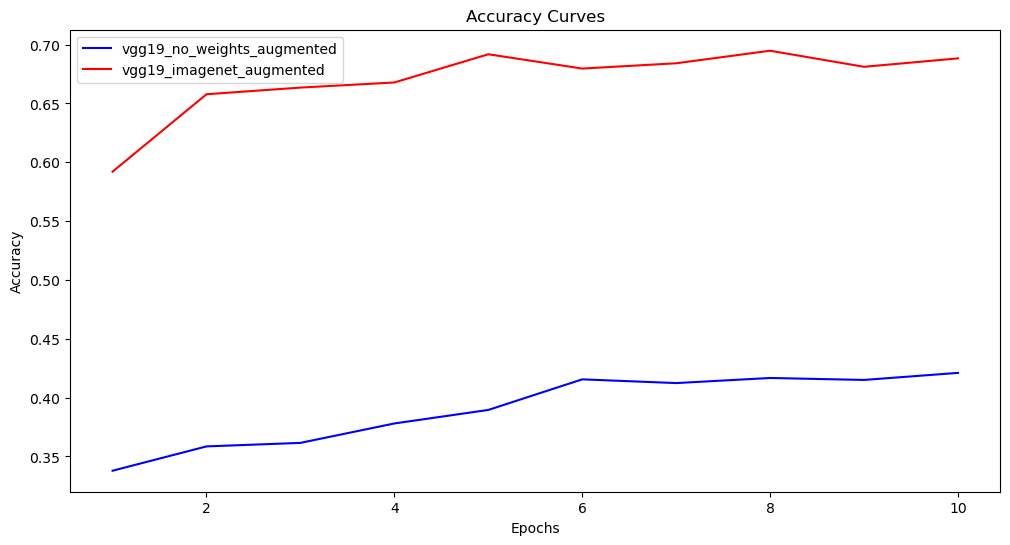

In [52]:
# Extract loss and accuracy values for both models
vgg19_no_weights_augmented_loss = vgg19_no_weights_augmented_history.history['loss']
vgg19_no_weights_augmented_accuracy = vgg19_no_weights_augmented_history.history['accuracy']
vgg19_imagenet_augmented_loss = vgg19_imagenet_augmented_history.history['loss']
vgg19_imagenet_augmented_accuracy = vgg19_imagenet_augmented_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_augmented_loss, 'b-', label='vgg19_no_weights_augmented')
plt.plot(range(1, 11), vgg19_imagenet_augmented_loss, 'r-', label='vgg19_imagenet_augmented')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_augmented_accuracy, 'b-', label='vgg19_no_weights_augmented')
plt.plot(range(1, 11), vgg19_imagenet_augmented_accuracy, 'r-', label='vgg19_imagenet_augmented')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Rebuild VGG19. After layer block4_conv4 (25, 25, 512):
    - Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    - Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    - Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    - Freeze conv2 layers and before

### VGG19 with no weights and normal training data Rebuilt

In [53]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_no_weights_normal_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_no_weights_normal_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_no_weights_normal_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_normal_rebuilt_history = vgg19_no_weights_normal_rebuilt.fit(training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_no_weights_normal_rebuilt.save("models/vgg19_no_weights_normal_rebuilt.h5")

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with no weights and augmented training data Rebuilt

In [54]:
# VGG19 no weights augmented data rebuilt
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_no_weights_augmented_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_no_weights_augmented_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_no_weights_augmented_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_no_weights_augmented_rebuilt_history = vgg19_no_weights_augmented_rebuilt.fit(augmented_training_set,validation_data=test_set, epochs=10, batch_size=32)

vgg19_no_weights_augmented_rebuilt.save("models/vgg19_no_weights_augmented_rebuilt.h5")

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with imagenet weights and normal training data Rebuilt

In [55]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_imagenet_normal_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_imagenet_normal_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_imagenet_normal_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_normal_rebuilt_history = vgg19_imagenet_normal_rebuilt.fit(training_set, validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_normal_rebuilt.save("models/vgg19_imagenet_normal_rebuilt.h5")

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### VGG19 with imagenet weights and augmented training data Rebuilt

In [56]:
# Rebuild VGG19
from keras.layers import Conv2D, LeakyReLU

# Get the VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Find the index of the desired layer to insert the new layers after
index = None
for i, layer in enumerate(vgg.layers):
    if layer.name == 'block4_conv4':
        index = i
        break

if index is not None:
    # Split the model into two parts based on the desired index
    vgg_layers = vgg.layers[:index+1]
    remaining_layers = vgg.layers[index+1:]

    for layer in vgg_layers:
        layer.trainable = False  # Freeze each layer

    # Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    inception = Conv2D(512, (1, 1), activation='relu')(vgg.layers[-1].output)
    inception.trainable = False
    # Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    conv = Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1))(inception)
    conv.trainable = False
    # Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    conv = Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu')(conv)
    conv.trainable = False

    # Freeze conv2 layers and before
    x = inception
    for layer in remaining_layers:
        x = layer(x)

    # Create the final prediction layer
    x = Flatten()(x)
    prediction = Dense(len(classes), activation='softmax')(x)

    # Create the rebuilt model
    vgg19_imagenet_augmented_rebuilt = Model(inputs=vgg.input, outputs=prediction)
    vgg19_imagenet_augmented_rebuilt.summary()
else:
    print("Desired layer 'block4_conv4' not found in VGG19 model.")

#Compile the model
vgg19_imagenet_augmented_rebuilt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg19_imagenet_augmented_rebuilt_history = vgg19_imagenet_augmented_rebuilt.fit(augmented_training_set, validation_data=test_set, epochs=10, batch_size=32)

vgg19_imagenet_augmented_rebuilt.save("models/vgg19_imagenet_augmented_rebuilt.h5")

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

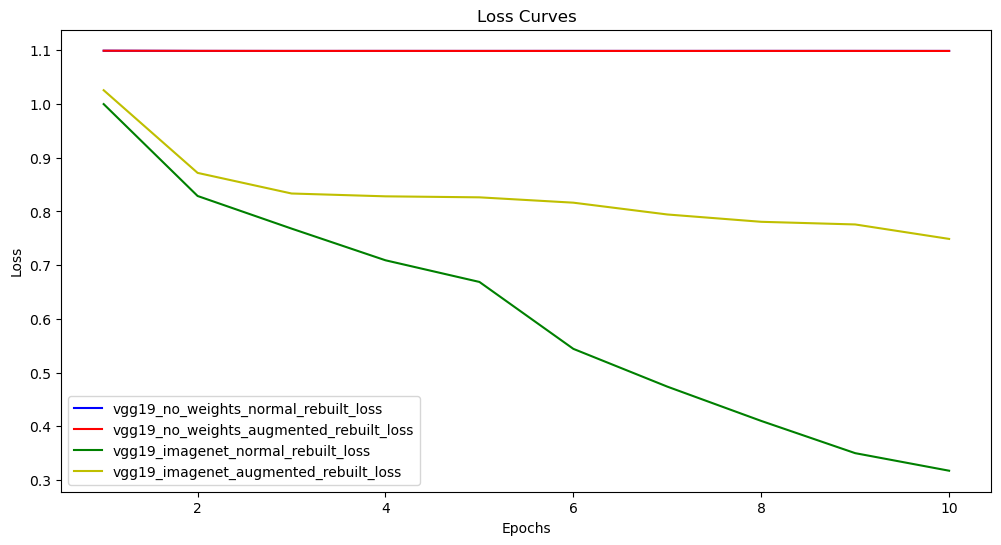

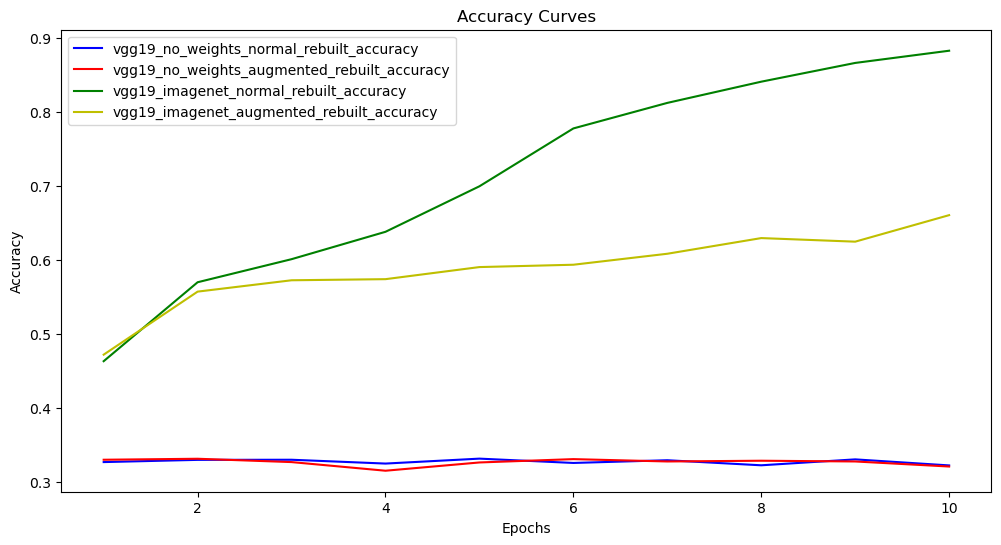

In [57]:
# Extract loss and accuracy values for both models
vgg19_no_weights_normal_rebuilt_loss = vgg19_no_weights_normal_rebuilt_history.history['loss']
vgg19_no_weights_normal_rebuilt_accuracy = vgg19_no_weights_normal_rebuilt_history.history['accuracy']

vgg19_no_weights_augmented_rebuilt_loss = vgg19_no_weights_augmented_rebuilt_history.history['loss']
vgg19_no_weights_augmented_rebuilt_accuracy = vgg19_no_weights_augmented_rebuilt_history.history['accuracy']

vgg19_imagenet_normal_rebuilt_loss = vgg19_imagenet_normal_rebuilt_history.history['loss']
vgg19_imagenet_normal_rebuilt_accuracy = vgg19_imagenet_normal_rebuilt_history.history['accuracy']

vgg19_imagenet_augmented_rebuilt_loss = vgg19_imagenet_augmented_rebuilt_history.history['loss']
vgg19_imagenet_augmented_rebuilt_accuracy = vgg19_imagenet_augmented_rebuilt_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_rebuilt_loss, 'b-', label='vgg19_no_weights_normal_rebuilt_loss')
plt.plot(range(1, 11), vgg19_no_weights_augmented_rebuilt_loss, 'r-', label='vgg19_no_weights_augmented_rebuilt_loss')
plt.plot(range(1, 11), vgg19_imagenet_normal_rebuilt_loss, 'g-', label='vgg19_imagenet_normal_rebuilt_loss')
plt.plot(range(1, 11), vgg19_imagenet_augmented_rebuilt_loss, 'y-', label='vgg19_imagenet_augmented_rebuilt_loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), vgg19_no_weights_normal_rebuilt_accuracy, 'b-', label='vgg19_no_weights_normal_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_no_weights_augmented_rebuilt_accuracy, 'r-', label='vgg19_no_weights_augmented_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_imagenet_normal_rebuilt_accuracy, 'g-', label='vgg19_imagenet_normal_rebuilt_accuracy')
plt.plot(range(1, 11), vgg19_imagenet_augmented_rebuilt_accuracy, 'y-', label='vgg19_imagenet_augmented_rebuilt_accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7. Test a few of your own images and present the results

In [72]:
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import utils
import numpy as np

# Preprocess your own images
path_i = "own_images"
image_filenames = []
for filename in os.listdir(path_i):
    if filename.endswith(".jpg"):
        image_filenames.append(filename)

print(image_filenames)

images = []
for img_path in image_filenames:
    img = utils.load_img(path_i+"\\" + img_path, target_size=(224, 224))
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    images.append(img)
images = np.concatenate(images, axis=0)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
df = pd.DataFrame(columns=['image', 'truth', 'result', 'models','cat', 'dog', 'person'])

# go through the models folder and save every filename in a list
model_filenames = []
path_m = "models"
for filename in os.listdir(path_m):
    if filename.endswith(".h5"):
        model_filenames.append(filename)

print(model_filenames)

models = []
for model_path in model_filenames:
    model = load_model( path_m+"\\"+ model_path)
    # Make predictions with each model on your own images
    predictions = model.predict(images)
    for i in range(len(image_filenames)):
        result = np.argmax(predictions[i])
        if result == 0:
            result = 'cat'
        elif result == 1:
            result = 'dog'
        else:
            result = 'person'
        df = df.append(
            {
                'models': model_path,
                'image': image_filenames[i],
                'cat': predictions[i][0],
                'dog': predictions[i][1],
                'person': predictions[i][2],
                'result': result,
                'truth': image_filenames[i].split('_')[0]
            },
            ignore_index=True
        )
# sort by image name
df = df.sort_values(by=['image'])

df.head(10000)





['cat_1.jpg', 'cat_2.jpg', 'cat_3.jpg', 'cat_x2.jpg', 'dog_1.jpg', 'dog_2.jpg', 'dog_3.jpg', 'dog_4.jpg', 'person_1.jpg', 'person_2.jpg', 'person_3.jpg', 'person_x4.jpg']
['vgg19_imagenet_augmented.h5', 'vgg19_imagenet_augmented_rebuilt.h5', 'vgg19_imagenet_normal.h5', 'vgg19_imagenet_normal_rebuilt.h5', 'vgg19_no_weights_augmented.h5', 'vgg19_no_weights_augmented_rebuilt.h5', 'vgg19_no_weights_normal.h5', 'vgg19_no_weights_normal_rebuilt.h5']
1/1 [==============================] - 0s 88ms/step


,image,truth,result,models,cat,dog,person
0,cat_1.jpg,cat,cat,vgg19_imagenet_augmented.h5,0.9827,0.0147,0.0026
24,cat_1.jpg,cat,cat,vgg19_imagenet_normal.h5,0.9286,0.0065,0.0649
48,cat_1.jpg,cat,cat,vgg19_no_weights_augmented.h5,0.3549,0.3510,0.2941
60,cat_1.jpg,cat,person,vgg19_no_weights_augmented_rebuilt.h5,0.3327,0.3333,0.3340
12,cat_1.jpg,cat,cat,vgg19_imagenet_augmented_rebuilt.h5,0.8495,0.1443,0.0062
...,...,...,...,...,...,...,...
35,person_x4.jpg,person,person,vgg19_imagenet_normal.h5,0.0000,0.0000,1.0000
23,person_x4.jpg,person,person,vgg19_imagenet_augmented_rebuilt.h5,0.0132,0.0641,0.9228
11,person_x4.jpg,person,person,vgg19_imagenet_augmented.h5,0.0234,0.2665,0.7100
83,person_x4.jpg,person,person,vgg19_no_weights_normal.h5,0.3096,0.3382,0.3522


In [73]:
# rank the models by counting truth == result
rank_temp = df
rank_temp['correct'] = rank_temp['truth'] == rank_temp['result']
rank_temp['correct'] = rank_temp['correct'].astype(int)
ranking = rank_temp.groupby(['models']).sum().sort_values(by=['correct'], ascending=False)
# calculate the percentage
ranking['percentage'] = ranking['correct'] / len(image_filenames)
# remove cat dog person
ranking = ranking.drop(['cat', 'dog', 'person'], axis=1)
ranking.head(10)

,correct,percentage
models,,
vgg19_imagenet_normal.h5,11,0.9167
vgg19_imagenet_augmented_rebuilt.h5,7,0.5833
vgg19_imagenet_normal_rebuilt.h5,7,0.5833
vgg19_no_weights_normal.h5,6,0.5000
vgg19_imagenet_augmented.h5,5,0.4167
vgg19_no_weights_augmented_rebuilt.h5,4,0.3333
vgg19_no_weights_normal_rebuilt.h5,4,0.3333
vgg19_no_weights_augmented.h5,3,0.2500


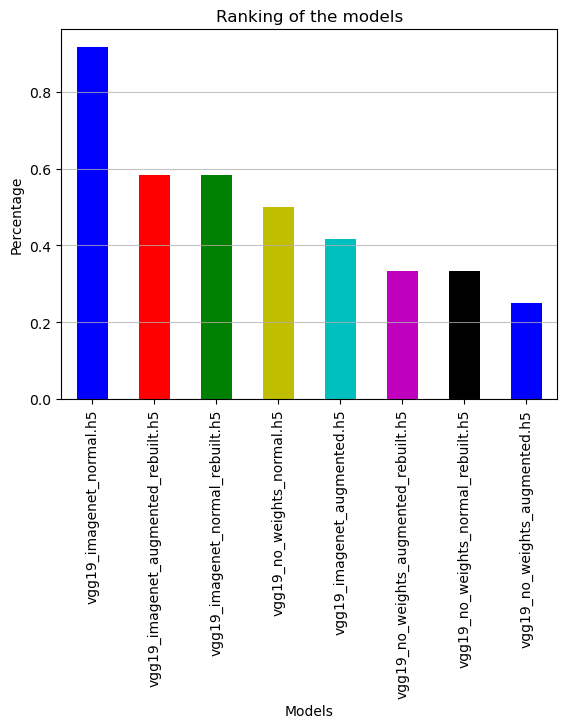

In [86]:
# plot the percentage as a bar chart different colors
ranking.plot.bar(y='percentage', rot=0, color=['b', 'r', 'g', 'y', 'c', 'm', 'k'])
plt.title('Ranking of the models')
plt.xlabel('Models')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.gca().legend_.remove()
# grid
plt.grid(axis='y', alpha=0.75)
plt.show()



8. Answer the following questions:
    - What accuracy can be achieved? What is the accuracy of the train vs. test set?
    - On what infrastructure did you train it? What is the inference time?
    - What are the number of parameters of the model?
    - Which categories are most likely to be confused by the algorithm? Show results in a confusion matrix.

Presentation
• 10 min per group
• Every group member must present at least one part
• Contents:
- What was project about?
- What experiments did you conduct? Discuss the results.
- What were issues? How did you solve them?
- What were your learnings?
- ...
• Conditions
- Not only showing code! More about the journey...